In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import joblib
import sys
import os

sys.path.append('../src')
from feature_engineer import MentalHealthFeatureEngineer

print("✅ Phase 3: Model Development")
print("Building on Phase 2 feature engineering...")

✅ Phase 3: Model Development
Building on Phase 2 feature engineering...


In [2]:
# Load the engineered data from Phase 2
df_engineered = pd.read_csv('../data/processed/engineered_mh_data.csv')
feature_importance = pd.read_csv('../data/processed/feature_importance.csv')

print("Engineered data shape:", df_engineered.shape)
print("Features available:", len(df_engineered.columns))
print("\nTop 10 features from Phase 2:")
print(feature_importance.head(10))

Engineered data shape: (1500, 27)
Features available: 27

Top 10 features from Phase 2:
                  feature     f_score       p_value
0     age_phq_interaction  442.065932  3.296845e-86
1             age_squared  242.034285  1.050099e-50
2                     age  228.548803  3.653569e-48
3      composite_mh_score  212.369215  4.356390e-45
4            phq9_squared  160.347711  5.496435e-35
5              phq9_score  157.265355  2.233625e-34
6             phq9_zscore  157.265355  2.233625e-34
7        age_group_Middle  101.550053  3.737402e-23
8  phq9_category_Moderate   97.821171  2.183871e-22
9       age_group_Elderly   85.610098  7.320596e-20


In [3]:
# Use the same feature engineering as Phase 2 to get processed features
engineer = MentalHealthFeatureEngineer()
X_processed, y, feature_names, _ = engineer.fit_transform(df_engineered)

print(f"Processed features: {X_processed.shape}")
print(f"Feature names: {len(feature_names)}")
print(f"Target distribution: {pd.Series(y).value_counts().to_dict()}")

Starting feature engineering...
✓ Clinical features created
✓ Statistical features created
Numeric features: ['age', 'phq9_score', 'gad7_score', 'bp_systolic', 'heart_rate', 'bmi', 'composite_mh_score', 'high_phq_high_bp', 'social_risk_score', 'phq9_zscore', 'age_squared', 'phq9_squared', 'age_phq_interaction', 'bmi_hr_interaction']
Categorical features: ['gender', 'education', 'employment', 'data_source', 'generation_date', 'phq9_category', 'gad7_category', 'bmi_category', 'age_group', 'bp_category']
✓ Preprocessing completed
✓ Final shape: (1500, 48)
✓ Total features: 48
Processed features: (1500, 48)
Feature names: 48
Target distribution: {0: 1054, 1: 446}


In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train target distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Test target distribution: {pd.Series(y_test).value_counts().to_dict()}")

Training set: (1200, 48)
Test set: (300, 48)
Train target distribution: {0: 843, 1: 357}
Test target distribution: {0: 211, 1: 89}


In [5]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42, class_weight='balanced')
}

# Train and evaluate models
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n{'='*40}")
    print(f"Training {name}")
    print(f"{'='*40}")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = model.score(X_test, y_test)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_processed, y, cv=cv, scoring='roc_auc')
    
    # Additional metrics
    from sklearn.metrics import precision_score, recall_score, f1_score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred_proba': y_pred_proba
    }
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"AUC: {auc:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"CV AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")


Training Logistic Regression
Accuracy: 0.727
AUC: 0.835
Precision: 0.529
Recall: 0.708
F1-Score: 0.606
CV AUC: 0.823 (+/- 0.053)

Training Random Forest
Accuracy: 0.763
AUC: 0.825
Precision: 0.680
Recall: 0.382
F1-Score: 0.489
CV AUC: 0.809 (+/- 0.050)

Training Gradient Boosting
Accuracy: 0.777
AUC: 0.830
Precision: 0.683
Recall: 0.461
F1-Score: 0.550
CV AUC: 0.811 (+/- 0.052)

Training SVM
Accuracy: 0.747
AUC: 0.817
Precision: 0.559
Recall: 0.697
F1-Score: 0.620
CV AUC: 0.811 (+/- 0.044)


In [6]:
# Compare model performance comprehensively
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results],
    'AUC': [results[name]['auc'] for name in results],
    'Precision': [results[name]['precision'] for name in results],
    'Recall': [results[name]['recall'] for name in results],
    'F1-Score': [results[name]['f1'] for name in results],
    'CV AUC Mean': [results[name]['cv_mean'] for name in results],
    'CV AUC Std': [results[name]['cv_std'] for name in results]
}).sort_values('AUC', ascending=False)

print("Model Performance Comparison (Sorted by AUC):")
print("="*60)
print(results_df.round(3))

Model Performance Comparison (Sorted by AUC):
                 Model  Accuracy    AUC  Precision  Recall  F1-Score  \
0  Logistic Regression     0.727  0.835      0.529   0.708     0.606   
2    Gradient Boosting     0.777  0.830      0.683   0.461     0.550   
1        Random Forest     0.763  0.825      0.680   0.382     0.489   
3                  SVM     0.747  0.817      0.559   0.697     0.620   

   CV AUC Mean  CV AUC Std  
0        0.823       0.026  
2        0.811       0.026  
1        0.809       0.025  
3        0.811       0.022  


In [7]:
# Feature importance from best model
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"\nFeature Importance Analysis for {best_model_name}")
print("="*50)

if hasattr(best_model, 'feature_importances_'):
    # Create feature importance dataframe
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title(f'Top 20 Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    print("Top 15 Most Important Features:")
    print(top_features.head(15).round(4))
    
    # Save feature importance
    feature_importance.to_csv('../data/processed/model_feature_importance.csv', index=False)
    print(f"\n✓ Feature importance saved for {best_model_name}")


Feature Importance Analysis for Logistic Regression


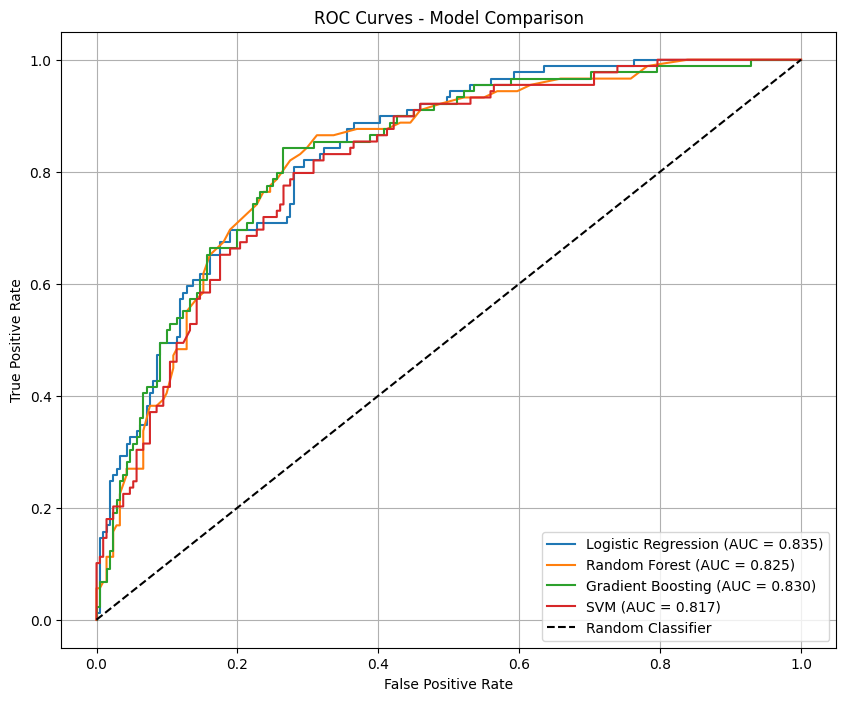

In [8]:
# ROC Curves for all models
plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    auc_score = result['auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
import os
import joblib
# Create models directory
os.makedirs('../models', exist_ok=True)
# Save the Best Model and Pipeline
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

# Create comprehensive model package
model_package = {
    'model': best_model,
    'preprocessor': engineer.preprocessor,
    'feature_names': feature_names,
    'model_name': best_model_name,
    'performance': results[best_model_name],
    'feature_importance': feature_importance if 'feature_importance' in locals() else None,
    'training_data_info': {
        'X_shape': X_processed.shape,
        'y_distribution': pd.Series(y).value_counts().to_dict(),
        'feature_columns': feature_names
    }
}

# Save model
joblib.dump(model_package, '../models/best_risk_model.pkl')

print(f"✅ BEST MODEL SAVED: {best_model_name}")
print(f"📊 Final Performance:")
print(f"   AUC: {results[best_model_name]['auc']:.3f}")
print(f"   Accuracy: {results[best_model_name]['accuracy']:.3f}")
print(f"   Precision: {results[best_model_name]['precision']:.3f}")
print(f"   Recall: {results[best_model_name]['recall']:.3f}")
print(f"📍 Saved to: '../models/best_risk_model.pkl'")

# Save performance comparison
results_df.to_csv('../data/processed/model_performance_comparison.csv', index=False)
print("✓ Model performance comparison saved")

✅ BEST MODEL SAVED: Logistic Regression
📊 Final Performance:
   AUC: 0.835
   Accuracy: 0.727
   Precision: 0.529
   Recall: 0.708
📍 Saved to: '../models/best_risk_model.pkl'
✓ Model performance comparison saved
